![data cube logo](https://static.wixstatic.com/media/8959d6_a13dc7ece5be4678af57c8f7c1667734~mv2.png/v1/fill/w_279,h_177,al_c,q_85,usm_0.66_1.00_0.01,enc_auto/VSDC_DataCubeSplash_6Partner_edited.png)
# Land Cover Change Mapping in Virginia

 - Sign up to the [VA Datacube](https://www.data4va.org/) to run this notebook interactively from a browser
 - <b>Compatibility</b>: Notebook currently compatible with the ...   

 - <b>Products used</b>: io_lulc


## Background


Land cover is the physical surface of the Earth, including trees, shrubs, grasses, soils, exposed rocks, water bodies, plantations, crops and built structures. Land cover changes for many reasons, including seasonal weather, severe weather events such as cyclones, floods and fires, and human activities such as mining, agriculture and urbanisation. We can use change mapping techniques to quantify how these processes influence land cover.

## Description

A <i>compulsory</i> description of the notebook, including a brief overview of how Digital Earth Australia helps to address the problem set out above. It can be good to include a run-down of the tools/methods that will be demonstrated in the notebook:

1. First we do this
2. Then we do this
3. Finally we do this

---------------------------------------------------------------------------------------------------------------------------

## Getting started


To run this analysis, run all the cells in the notebook starting with the ‘Load packages and connect to the datacube’ cell.

### Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. Begin with any iPython magic commands, followed by standard Python packages, then any additional functionality you need from the Scripts directory.

In [5]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import sys, os
from odc.ui import DcViewer

from deafrica_tools.plotting import rgb, display_map
from matplotlib import colors as mcolours
#from deafrica_tools.landcover import plot_land_cover, lc_colourmap, make_colorbar

### Connect to the datacube

Connect to the datacube so we can access DEA data. The app parameter is a unique name for the analysis which is based on the notebook file name

In [6]:
dc = datacube.Datacube(app='Land_Cover_Change_Mapping')

### Analysis parameters
An optional section to inform the user of any parameters they'll need to configure to run the notebook:
 - param_name_1: Simple description (e.g. example_value). Advice about appropriate values to choose for this parameter.
 - param_name_2: Simple description (e.g. example_value). Advice about appropriate values to choose for this parameter.

 

In [7]:
param_name_1 = 'example_value'
param_name_2 = 'example_value'

## Preview, select and view your study area

<b>If running the notebook for the first time</b>, keep the default settings below. This will demonstrate how the change mapping functionality works and provide meaningful results. The following example will load data for the Hampton Roads area in southeastern Virginia. But first, we will view what data is available for the area.


In [9]:
#View landcover data set
land_cover = DcViewer(
    dc, 
    time='2020',
    zoom=3,
    center=(30,-20),
    height='720px', width='1280px',
    products=['io_lulc'],
    style={'fillOpacity': 0.05,
            'color': 'teal',
            'weight': 0.7})
land_cover

#Years available are 2020 and 2021. 

#Codes:
# 1 = Water
# 2 = Forest
# 4 = Flooded Veg
# 5 = Crops
# 7 = Built Area
# 8 = Bare ground
# 9 = Snow/ice
# 10 = clouds
# 11 = Rangelands

In [27]:
# Define area of interest and buffer values
lat, lon = (36.9, -76.2)

lat_buffer = 0.5
lon_buffer = 0.5

# Combine central coordinates with buffer to get area of interest
lat_range = (lat - lat_buffer, lat + lat_buffer)
lon_range = (lon - lon_buffer, lon + lon_buffer)


The following cell will display the area of interest on an interactive map. You can zoom in and out to better understand the area you’ll be analyzing.

In [28]:
display_map(x=lon_range, y=lat_range)

In [50]:
#Appears we have 2020 to 2021 data available from the data viewer

# Set the range of dates for the analysis
time_range = ("2020", "2021")

## Load and view `io_lulc` data

The following cell will load `io_lulc` data for the lat_range, lon_range and time_range we defined above.

In [36]:
# Create the 'query' dictionary object, which contains the longitudes, latitudes and time defined above
query = {
    "y": lat_range,
    "x": lon_range,
    "time": time_range,
}

# Load DEA Land Cover data from the datacube
lc = dc.load(
    product="io_lulc",
    output_crs="epsg:4326", # WGS 1984 
    resolution=(-.00027, .00027),
    **query
)

lc


<xarray.Dataset>
Dimensions:      (time: 1, latitude: 3705, longitude: 3705)
Coordinates:
  * time         (time) datetime64[ns] 2020-07-02
  * latitude     (latitude) float64 37.4 37.4 37.4 37.4 ... 36.4 36.4 36.4 36.4
  * longitude    (longitude) float64 -76.7 -76.7 -76.7 ... -75.7 -75.7 -75.7
    spatial_ref  int32 4326
Data variables:
    data         (time, latitude, longitude) uint8 2 2 2 2 2 2 2 ... 0 0 0 0 0 0
Attributes:
    crs:           epsg:4326
    grid_mapping:  spatial_ref

Establish a color map for the land cover types.

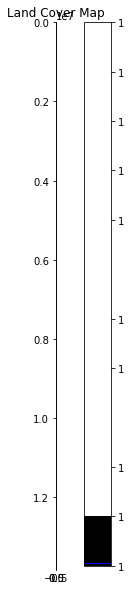

In [52]:

# Create the 'query' dictionary object, which contains the longitudes, latitudes and time defined above
query = {
    "y": lat_range,
    "x": lon_range,
    "time": time_range,
}

# Load DEA Land Cover data from the datacube
lc = dc.load(
    product="io_lulc",
    output_crs="epsg:4326", # WGS 1984 
    resolution=(-.00027, .00027),
    **query
)

lc

# Convert the dataset to a pandas dataframe
df = lc.to_dataframe()

# Pivot the dataframe to create a 2D array of the level3 values
pivot = pd.pivot_table(df, values='data', columns='time', index=['latitude', 'longitude'])
level3 = pivot.values

# Create a color map for the land cover types divided by 255
color_map = {
    0: (1, 1, 1, 1),
    1: (0.255, 0.608, 0.875, 1),
    2: (0.224, 0.49, 0.286, 1),
    4: (0.533, 0.69, 0.325, 1),
    5: (0.478, 0.529, 0.776, 1),
    7: (0.894, 0.588, 0.208, 1),
    8: (0.875, 0.765, 0.353, 1),
    9: (0.769, 0.157, 0.106, 1),
    10: (0.647, 0.608, 0.561, 1),
    11: (0.659, 0.922, 1, 1),
}

# Create a color map array
colors = np.zeros((256, 4), dtype=np.uint8)
for k, v in color_map.items():
    colors[k, :] = v

# Create the land cover image
land_cover = colors[level3.flatten()].reshape(level3.shape + (4,))

# Create the figure
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the land cover image
ax.imshow(land_cover)

# Add a colorbar
cmap = plt.cm.colors.ListedColormap(colors)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=ax)
cbar.set_ticks(list(color_map.keys()))
cbar.set_ticklabels([color_map[k][-1] for k in color_map])

# Add a title
ax.set_title('Land Cover Map')

# Show the plot
plt.show()


## Heading 2

Use markdown text for detailed, descriptive text explaining what the code below does and why it is needed.


## Additional information

<b>License:</b> The code in this notebook is licensed under the Apache License, Version 2.0. Digital Earth Australia data is licensed under the Creative Commons by Attribution 4.0 license.

<b>Contact:</b> If you need assistance, please post a question on the Open Data Cube Slack channel or on the GIS Stack Exchange using the open-data-cube tag (you can view previously asked questions here). If you would like to report an issue with this notebook, you can file one on Github.

<b>Last modified:</b> May 2020

<b>Compatible datacube version:</b>

In [ ]:
print(datacube.__version__)

## Tags 
Browse all available tags on the VA Data Cube User Guide's Tags Index 